In [2]:
using DifferentialEquations
using Plots
using LaTeXStrings
pgfplotsx()

Plots.PGFPlotsXBackend()

Consider the simple reaction:

\begin{align}
    A &\longrightarrow B\\
\end{align}

The reaction is elementary, and B acts as a solvent for A and the transition state. We will consider it in a few different solvent environments. 

In [3]:
function batch(du, u, p, t)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k10, V = PAR
    
    NA  = u[:,1]
    NB  = u[:,2]

    NT  = NA + NB
    
    XA   = NA./NT
    XB   = NB./NT
    
    #For A in solvent
    A12A = MAR[1]
    
    #For B in solvent
    A12B = MAR[2]
    
    #For Transition State 1 in solvent
    A12TS1 = MAR[3]
    
    gammaA  = exp.(XB.^2*A12A)
    gammaB  = exp.(XA.^2*A12B)

    gammaTS1 = exp.(XB.^2*A12TS1)

    r1 = k10*gammaA./gammaTS1.*XA.*NT/V
    
    aA = gammaA.*XA
    
    RA  = -r1[1]
    RB  =  r1[1]
    
    du[1] = RA*V
    du[2] = RB*V
    return du, r1, aA
end

batch (generic function with 1 method)

In [4]:
k10  = 1
V    = 1

NA0  = 1
NB0  = 0

var0     = [NA0 NB0]
span     = (0.0, 1000.0);

In [5]:
#Solvate transition state relative to reactants
MARSET1 = zeros(3,3)
MARSET1[:,1] = [0.0,  0.0,  0.0] #no solvation
MARSET1[:,2] = [0.0,  0.0,  2.0] #destabilize TS1
MARSET1[:,3] = [0.0,  0.0, -2.0] #stabilize TS1

tfine  = 10 .^(range(-3.0, stop = log10(maximum(span)), length = 1000))
Xout   = zeros(length(tfine), size(MARSET1, 2))
r1out  = zeros(length(tfine), size(MARSET1, 2))
NAout  = zeros(length(tfine), size(MARSET1, 2))
NBout  = zeros(length(tfine), size(MARSET1, 2))
aAout  = zeros(length(tfine), size(MARSET1, 2))

for i = 1:size(MARSET1, 2)
    p0   = Dict("MAR" => MARSET1[:,i], "PAR" => [k10, V])
    prob = ODEProblem(batch, var0, span, p0)
    sol  = solve(prob, Rodas5(), abstol = 1e-18, reltol = 1e-18)
    solf = sol(tfine)
    NA   = solf[1,:]
    NB   = solf[2,:]
    NT   = NA + NB
    ext  = NB/NA0
    dut, rt1, aAt = batch([0., 0.], [NA NB], p0, tfine)

    Xout[:,i]  = ext
    r1out[:,i] = rt1
    NAout[:,i] = NA
    NBout[:,i] = NB
    aAout[:,i] = aAt
end


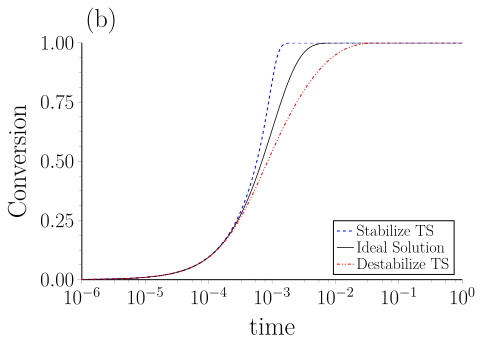

In [6]:
#Create Plot 1
plt1 = plot(
    xscale  = :log10, 
    xlim    = (1e-6, 1),
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = (0.0:0.25:1.0),
    #yticks = (-2.0:1.0:2.0, [@sprintf("%1.1f", x) for x in -2.0:1.0:2.0]),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 26, 
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = "Conversion", 
    fontfamily = "Times Roman",
    legendfontsize = 16,
    legendfonthalign = :left,
    legend  = :bottomright,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 26
)

plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,3],  ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize TS")
plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,1],  ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,2],  ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize TS")
display(plt1)
savefig(plt1, "CS1b1.pdf")

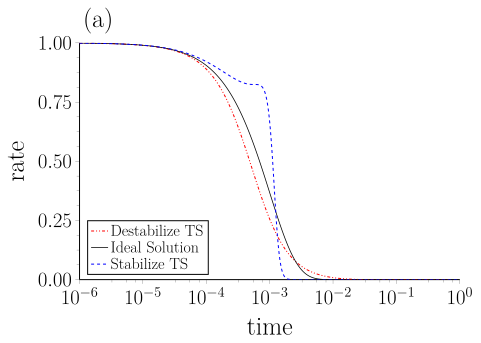

In [7]:
idx1 = r1out[:,1] .>= 0
idx2 = r1out[:,2] .>= 0
idx3 = r1out[:,3] .>= 0

plt2 = plot(
    xscale  = :log10, 
    xlim    = (1e-6, 1),
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = (0.0:0.25:1.0),
    #yticks = (-2.0:1.0:2.0, [@sprintf("%1.1f", x) for x in -2.0:1.0:2.0]),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 26, 
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = "rate", 
    fontfamily = "Times Roman",
    legendfontsize = 16,
    legendfonthalign = :left,
    legend  = :bottomleft,
    title = "(a)",
    titlelocation = :left,
    titlefontsize = 26
)

plt2 = plot!(plt2, tfine[idx2]/maximum(tfine), r1out[:,2][idx2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize TS")
plt2 = plot!(plt2, tfine[idx1]/maximum(tfine), r1out[:,1][idx1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt2 = plot!(plt2, tfine[idx3]/maximum(tfine), r1out[:,3][idx3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize TS")
display(plt2)
savefig(plt2, "CS1b2.pdf")

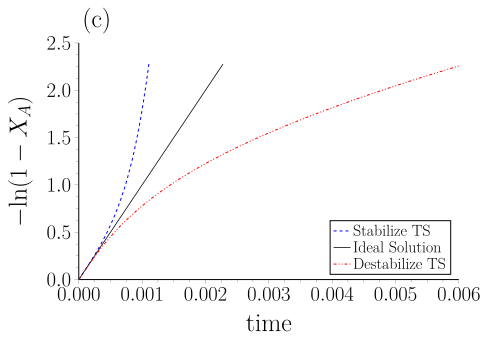

In [8]:
idx1 = Xout[:,1] .< 0.9
idx2 = Xout[:,2] .< 0.9
idx3 = Xout[:,3] .< 0.9

plt3 = plot(
    xlim    = (0.0, 0.006),
    xminorticks = 4,
    ylim = (0.0, 2.5),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 26, 
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = L"-\textrm{ln}(1 - X_A)", 
    fontfamily = "Times Roman",
    legendfontsize = 16,
    legendfonthalign = :left,
    legend  = :bottomright,
    title = "(c)",
    titlelocation = :left,
    titlefontsize = 26
)

plt3 = plot!(plt3, tfine[idx3]/maximum(tfine), -log.(1 .- Xout[:,3][idx3]), ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize TS")
plt3 = plot!(plt3, tfine[idx1]/maximum(tfine), -log.(1 .- Xout[:,1][idx1]), ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt3 = plot!(plt3, tfine[idx2]/maximum(tfine), -log.(1 .- Xout[:,2][idx2]), ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize TS")

display(plt3)
savefig(plt3, "CS1b3.pdf")

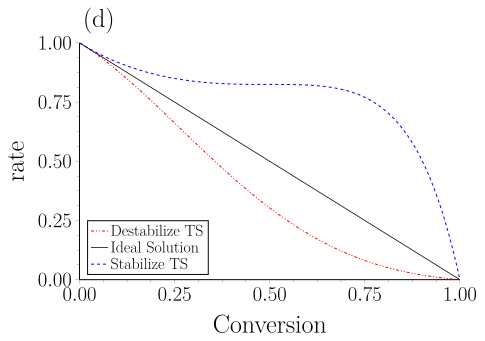

In [9]:
plt4 = plot(
    xlim    = (0.0, 1.0),
    xticks  = 0.0:0.25:1.0,
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = 0.0:0.25:1.0,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 26, 
    tickfontsize = 20,
    xlabel  = "Conversion", 
    ylabel  = "rate", 
    fontfamily = "Times Roman",
    legendfontsize = 16,
    legendfonthalign = :left,
    legend  = :bottomleft,
    title = "(d)",
    titlelocation = :left,
    titlefontsize = 26
)

plt4 = plot!(plt4, Xout[:,2], r1out[:,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize TS")
plt4 = plot!(plt4, Xout[:,1], r1out[:,1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt4 = plot!(plt4, Xout[:,3], r1out[:,3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize TS")
display(plt4)
savefig(plt4, "CS1b4.pdf")

In [10]:
#Solvate transition state relative to reactants
MARSET1 = zeros(3,3)
MARSET1[:,1] = [0.0,   0.0,  0.0] #no solvation
MARSET1[:,2] = [2.0,   0.0,  0.0] #destabilize TS1
MARSET1[:,3] = [-2.0,  0.0,  0.0] #stabilize TS1

tfine  = 10 .^(range(-3.0, stop = log10(maximum(span)), length = 1000))
Xout   = zeros(length(tfine), size(MARSET1, 2))
r1out2  = zeros(length(tfine), size(MARSET1, 2))
NAout  = zeros(length(tfine), size(MARSET1, 2))
NBout  = zeros(length(tfine), size(MARSET1, 2))
aAout2  = zeros(length(tfine), size(MARSET1, 2))

for i = 1:size(MARSET1, 2)
    p0   = Dict("MAR" => MARSET1[:,i], "PAR" => [k10, V])
    prob = ODEProblem(batch, var0, span, p0)
    sol  = solve(prob, Rodas5(), abstol = 1e-18, reltol = 1e-18)
    solf = sol(tfine)
    NA   = solf[1,:]
    NB   = solf[2,:]
    NT   = NA + NB
    ext  = NB/NA0
    dut, rt1, aAt = batch([0., 0.], [NA NB], p0, tfine)

    Xout[:,i]  = ext
    r1out2[:,i] = rt1
    NAout[:,i] = NA
    NBout[:,i] = NB
    aAout2[:,i] = aAt
end


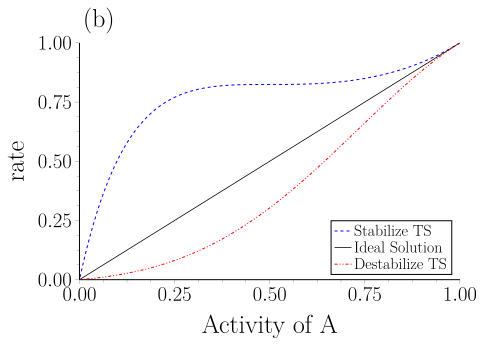

In [11]:
plt5 = plot(
    xlim    = (0.0, 1.0),
    xticks  = 0.0:0.25:1.0,
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = 0.0:0.25:1.0,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 26, 
    tickfontsize = 20,
    xlabel  = "Activity of A", 
    ylabel  = "rate", 
    fontfamily = "Times Roman",
    legendfontsize = 16,
    legendfonthalign = :left,
    legend  = :bottomright,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 26
)

plt5 = plot!(plt5, aAout[:,3], r1out[:,3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize TS")
plt5 = plot!(plt5, aAout[:,1], r1out[:,1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt5 = plot!(plt5, aAout[:,2], r1out[:,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize TS")

display(plt5)
savefig(plt5, "CS1b5.pdf")

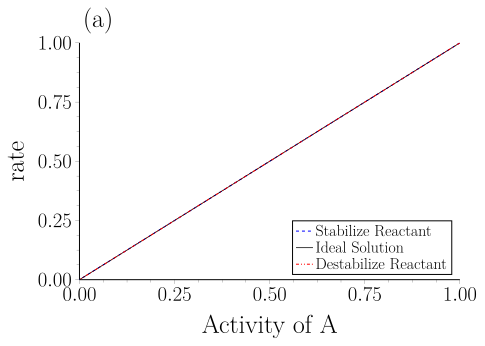

In [12]:
plt6 = plot(
    xlim    = (0.0, 1.0),
    xticks  = 0.0:0.25:1.0,
    xminorticks = 4,
    ylim = (0.0, 1.0),
    yticks = 0.0:0.25:1.0,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 26, 
    tickfontsize = 20,
    xlabel  = "Activity of A", 
    ylabel  = "rate", 
    fontfamily = "Times Roman",
    legendfontsize = 16,
    legendfonthalign = :left,
    legend  = :bottomright,
    title = "(a)",
    titlelocation = :left,
    titlefontsize = 26
)

plt6 = plot!(plt6, aAout2[:,3], r1out2[:,3], ls = :dash,       lc = :blue,  lw = 1.00, label = "Stabilize Reactant")
plt6 = plot!(plt6, aAout2[:,1], r1out2[:,1], ls = :solid,      lc = :black, lw = 0.75, label = "Ideal Solution")
plt6 = plot!(plt6, aAout2[:,2], r1out2[:,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = "Destabilize Reactant")

display(plt6)
savefig(plt6, "CS1b6.pdf")